In [58]:
"""
Importing required libraries
"""
import sys
import sklearn
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.decomposition import FastICA, PCA
from sklearn import random_projection
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import silhouette_score,confusion_matrix,classification_report,plot_confusion_matrix
from sklearn.metrics import silhouette_samples
from sklearn.metrics import mean_squared_error
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.metrics import adjusted_mutual_info_score,mutual_info_score,adjusted_rand_score,homogeneity_completeness_v_measure
from time import time
from scipy.io.arff import loadarff 
import numpy as np
import itertools
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)
import tensorflow as tf
from tensorflow import keras

import os
from matplotlib.colors import LogNorm
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
random_state = np.random.RandomState(17)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Dataset 
Refrences:
- https://www.kaggle.com/ronitf/heart-disease-uci
- https://archive.ics.uci.edu/ml/datasets/Heart+Disease
- https://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set

## Dataset Attribute Information:
Dataset name: Messidor (Diabetic Retinopathy Debrecen)
following description of fetures are obtainbed from: https://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set

- 0) quality of image (Binart 0:Bad 1: acceptable)
- 1) pre-screening indication of disease 0: no sign 1: disease is present
- 2-7) " The results of MA detection. Each feature value stand for the
        number of MAs found at the confidence levels alpha = 0.5, . . . , 1, respectively".
- 8-15) similar to (2-7) for exudates. see refrence for more information.
- 16) The euclidean distance feture of patients retina
- 17) optic disc diameter.
- 18) AM/FM based class (binary).
- 19) 1 = contains signs disease, 0 = no signs

In [3]:
messidor_data_path = os.path.join("Data", "messidor_features.arff")
messidor_data = loadarff(messidor_data_path)
messidor = pd.DataFrame(messidor_data[0])
messidor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 20 columns):
0        1151 non-null float64
1        1151 non-null float64
2        1151 non-null float64
3        1151 non-null float64
4        1151 non-null float64
5        1151 non-null float64
6        1151 non-null float64
7        1151 non-null float64
8        1151 non-null float64
9        1151 non-null float64
10       1151 non-null float64
11       1151 non-null float64
12       1151 non-null float64
13       1151 non-null float64
14       1151 non-null float64
15       1151 non-null float64
16       1151 non-null float64
17       1151 non-null float64
18       1151 non-null float64
Class    1151 non-null object
dtypes: float64(19), object(1)
memory usage: 180.0+ KB


In [4]:
messidor["Class"].value_counts()

b'1'    611
b'0'    540
Name: Class, dtype: int64

## Load/Split/Process Data:

In [27]:
messidor_train_set, messidor_test_set = train_test_split(messidor, test_size=0.2, random_state=17)
# Separate predictors and labels for messidor data
messidor_train_features = messidor_train_set.drop("Class",axis=1)
messidor_train_labels = messidor_train_set["Class"].copy()
# identifying the categorical and numerical data for messidor data
messidor_cat_attrs = ['0','1','18']
messidor_num_attrs = [c for c in messidor_train_features.columns if c not in messidor_cat_attrs ]
messidor_train_labels.value_counts()

# preprocessing the messidor data
pipeline = ColumnTransformer([
        ("num", StandardScaler(), messidor_num_attrs),
        ("cat", OneHotEncoder(), messidor_cat_attrs),
    ])
    
X = pipeline.fit_transform(messidor_train_features)
ordinal_encoder = LabelEncoder()
y = ordinal_encoder.fit_transform(messidor_train_labels)
# messidor test set preprocessing
messidor_test_features = messidor_test_set.drop("Class",axis=1)
messidor_test_prep = pipeline.transform(messidor_test_features)
messidor_test_labels = messidor_test_set["Class"].copy()
messidor_test_labels_prep = ordinal_encoder.transform(messidor_test_labels)
Class_label=['No signs of DR','Contains signs of DR']

In [56]:
def plot_clusters(X, y=None,s=4):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=s)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

def plot_data(X,y_true=None):
    # plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    # plt.plot(X[:, 0], X[:, 1], 'k.',color=y_true, markersize=2)
    plt.scatter(X[:, 0], X[:, 1], c=y_true,s=3)
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X,y_true=None, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X,y_true)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');


Saving figure messidor_plot


<Figure size 800x400 with 0 Axes>

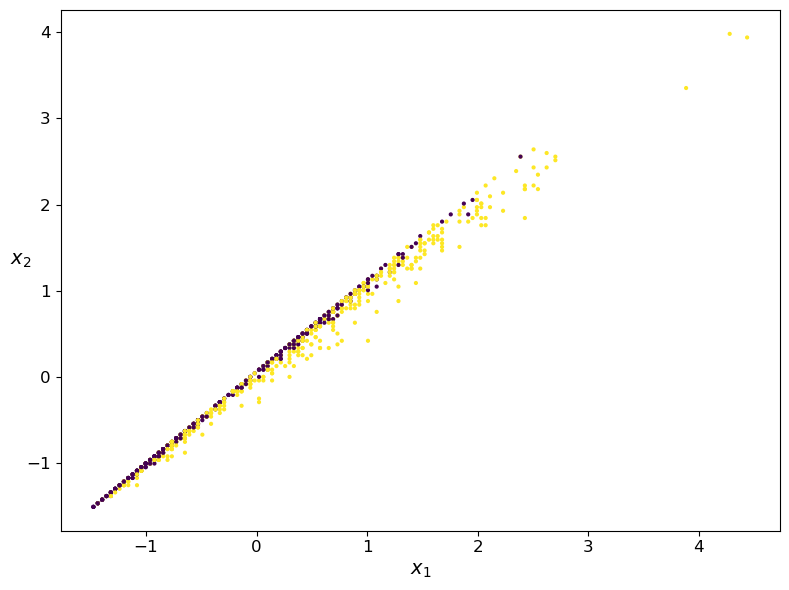

In [7]:
plt.figure(figsize=(8, 4))
plot_clusters(X,y)
save_fig("messidor_plot")
plt.show()

In [27]:

def nn_parameter_study(X,y,n=300,l=1,lr=0.01,epochs=200,range_n=None,num_layer=None,range_lr=None):
    
    early_stopping = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

    v_range =[]
    train_score=[]
    val_score=[]
    if range_n is not None:
        v_range = range_n
        x_label='Number of Neurons'
    elif range_lr is not None:
        v_range = range_lr
        x_label='Learning Rate'
    else:
        v_range = np.arange(1,num_layer+1)
        x_label='Number of Layers'
    for v in v_range:
        tf.keras.backend.clear_session()
        model = keras.models.Sequential()
        model.add(keras.layers.InputLayer(input_shape=X.shape[1]))
        for i in range(l if num_layer is None else v): 
            model.add(keras.layers.Dense(n if range_n is None else v, activation="relu"))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(loss="binary_crossentropy", optimizer =keras.optimizers.SGD(lr=lr if range_lr is None else v),metrics = ["accuracy"])
        model_history = model.fit(X,y,epochs=epochs,validation_split=0.2,callbacks=[early_stopping])
        
        
        train_score.append(model_history.history['accuracy'][-1])
        val_score.append(model_history.history['val_accuracy'][-1])
    plt.plot(v_range,train_score, "g-", linewidth=2, label="train_score")
    plt.plot(v_range,val_score, "y-", linewidth=3, label="val_score")
    plt.legend(loc="lower right", fontsize=14)  
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel("Score", fontsize=14)
    plt.title("Hyperparameter Study -NN", fontsize=14)
    # plt.gca().set_ylim(0, 1)
    plt.show()

# Custering Algorithms as Features for NN model:

## K- Means:

In [29]:
kmeans_optimum = KMeans(n_clusters=3, random_state=9)
y_k_means = kmeans_optimum.fit_predict(X)

In [30]:
centers = kmeans_optimum.cluster_centers_

In [43]:
dist_feature = kmeans_optimum.transform(X)
scaler = StandardScaler()
X_dist = scaler.fit_transform(dist_feature)
dist_feature[0]

array([ 4.54383439,  8.4395417 , 16.80609167])

## Using cluster labels as features:

In [32]:
hot_encoder = OneHotEncoder()
x_k_mean = (hot_encoder.fit_transform(y_k_means.reshape(-1, 1))).toarray()

Train on 736 samples, validate on 184 samples
Epoch 1/200
736/736 [==============================] - 1s 695us/sample - loss: 0.7089 - accuracy: 0.5326 - val_loss: 0.7132 - val_accuracy: 0.4946
Epoch 2/200
736/736 [==============================] - 0s 64us/sample - loss: 0.7054 - accuracy: 0.5326 - val_loss: 0.7100 - val_accuracy: 0.4946
Epoch 3/200
736/736 [==============================] - 0s 75us/sample - loss: 0.7025 - accuracy: 0.5326 - val_loss: 0.7075 - val_accuracy: 0.4946
Epoch 4/200
736/736 [==============================] - 0s 69us/sample - loss: 0.7002 - accuracy: 0.5326 - val_loss: 0.7056 - val_accuracy: 0.4946
Epoch 5/200
736/736 [==============================] - 0s 80us/sample - loss: 0.6984 - accuracy: 0.5326 - val_loss: 0.7041 - val_accuracy: 0.4946
Epoch 6/200
736/736 [==============================] - 0s 72us/sample - loss: 0.6968 - accuracy: 0.5326 - val_loss: 0.7028 - val_accuracy: 0.4946
Epoch 7/200
736/736 [==============================] - 0s 68us/sample - loss:

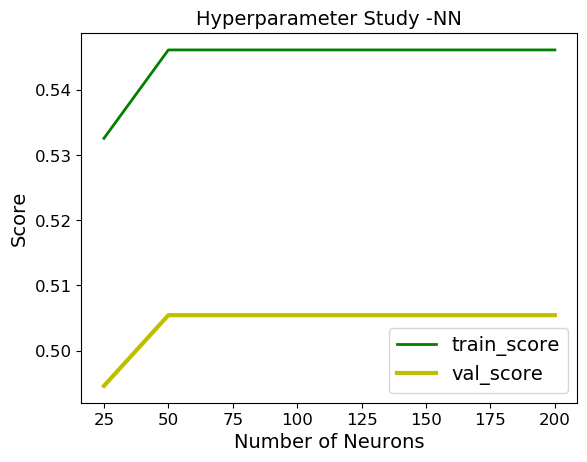

In [30]:
# number of neurons vs score
range_n=[25,50,100,200]
nn_parameter_study(x_k_mean,y,n=100,l=1,lr=0.01,epochs=200,range_n=range_n,range_lr=None)

Train on 736 samples, validate on 184 samples
Epoch 1/300
736/736 [==============================] - 1s 812us/sample - loss: 0.6881 - accuracy: 0.5462 - val_loss: 0.6919 - val_accuracy: 0.5054
Epoch 2/300
736/736 [==============================] - 0s 94us/sample - loss: 0.6872 - accuracy: 0.5462 - val_loss: 0.6920 - val_accuracy: 0.5054
Epoch 3/300
736/736 [==============================] - 0s 82us/sample - loss: 0.6866 - accuracy: 0.5462 - val_loss: 0.6920 - val_accuracy: 0.5054
Epoch 4/300
736/736 [==============================] - 0s 110us/sample - loss: 0.6860 - accuracy: 0.5462 - val_loss: 0.6922 - val_accuracy: 0.5054
Epoch 5/300
736/736 [==============================] - 0s 74us/sample - loss: 0.6854 - accuracy: 0.5462 - val_loss: 0.6923 - val_accuracy: 0.5054
Epoch 6/300
736/736 [==============================] - 0s 83us/sample - loss: 0.6850 - accuracy: 0.5462 - val_loss: 0.6924 - val_accuracy: 0.5054
Epoch 7/300
736/736 [==============================] - 0s 113us/sample - los

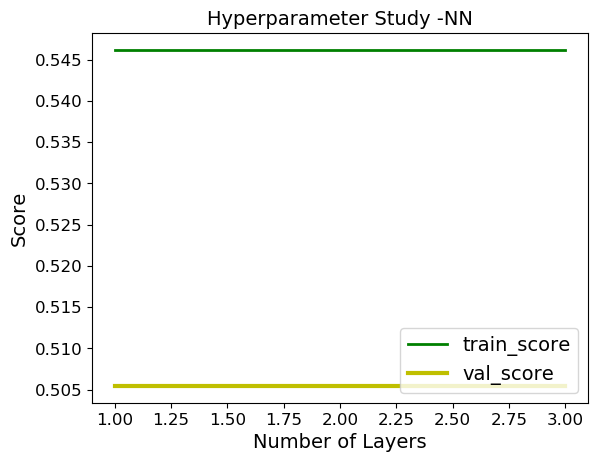

In [36]:
nn_parameter_study(x_k_mean,y,n=50,lr=0.01,l=2,epochs=300,range_n=None,num_layer=3,range_lr=None)

Train on 736 samples, validate on 184 samples
Epoch 1/200
736/736 [==============================] - 1s 726us/sample - loss: 0.6927 - accuracy: 0.5421 - val_loss: 0.6936 - val_accuracy: 0.5163
Epoch 2/200
736/736 [==============================] - 0s 93us/sample - loss: 0.6925 - accuracy: 0.5421 - val_loss: 0.6935 - val_accuracy: 0.5163
Epoch 3/200
736/736 [==============================] - 0s 80us/sample - loss: 0.6923 - accuracy: 0.5421 - val_loss: 0.6934 - val_accuracy: 0.5163
Epoch 4/200
736/736 [==============================] - 0s 92us/sample - loss: 0.6921 - accuracy: 0.5421 - val_loss: 0.6933 - val_accuracy: 0.5163
Epoch 5/200
736/736 [==============================] - 0s 91us/sample - loss: 0.6919 - accuracy: 0.5421 - val_loss: 0.6932 - val_accuracy: 0.5163
Epoch 6/200
736/736 [==============================] - 0s 94us/sample - loss: 0.6916 - accuracy: 0.5421 - val_loss: 0.6932 - val_accuracy: 0.5163
Epoch 7/200
736/736 [==============================] - 0s 88us/sample - loss:

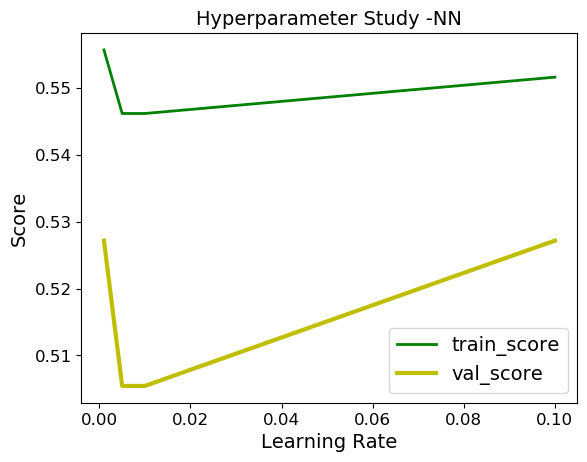

In [37]:
range_lr =[0.001,0.005,0.01,0.1]
nn_parameter_study(x_k_mean,y,n=50,lr=0.01,l=1,epochs=200,range_n=None,range_lr=range_lr)

In [33]:
# Creating MLP
tf.keras.backend.clear_session()

model_NN_k_means = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=x_k_mean.shape[1]),
    keras.layers.Dense(50, activation="relu"),


    keras.layers.Dense(1, activation="sigmoid")])

In [34]:
model_NN_k_means.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                200       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________


In [35]:
model_NN_k_means.compile(loss="binary_crossentropy",
              optimizer =keras.optimizers.SGD(lr=0.001),
              metrics = ["accuracy"])

In [36]:
early_stopping = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
model_history_k_means = model_NN_k_means.fit(x_k_mean,y,epochs=300,validation_split=0.2,callbacks=[early_stopping])

Train on 736 samples, validate on 184 samples
Epoch 1/300
736/736 [==============================] - 1s 688us/sample - loss: 0.7087 - accuracy: 0.4538 - val_loss: 0.7002 - val_accuracy: 0.4946
Epoch 2/300
736/736 [==============================] - 0s 90us/sample - loss: 0.7081 - accuracy: 0.4538 - val_loss: 0.6999 - val_accuracy: 0.4946
Epoch 3/300
736/736 [==============================] - 0s 68us/sample - loss: 0.7075 - accuracy: 0.4538 - val_loss: 0.6996 - val_accuracy: 0.4946
Epoch 4/300
736/736 [==============================] - 0s 65us/sample - loss: 0.7070 - accuracy: 0.4538 - val_loss: 0.6993 - val_accuracy: 0.4946
Epoch 5/300
736/736 [==============================] - 0s 80us/sample - loss: 0.7065 - accuracy: 0.4538 - val_loss: 0.6991 - val_accuracy: 0.4946
Epoch 6/300
736/736 [==============================] - 0s 61us/sample - loss: 0.7060 - accuracy: 0.4538 - val_loss: 0.6988 - val_accuracy: 0.4946
Epoch 7/300
736/736 [==============================] - 0s 87us/sample - loss:

In [37]:
model_history_k_means.history['val_accuracy'][-1],model_history_k_means.history['accuracy'][-1]

(0.49456522, 0.5326087)

Saving figure k_means_keras_learning_curves_plot


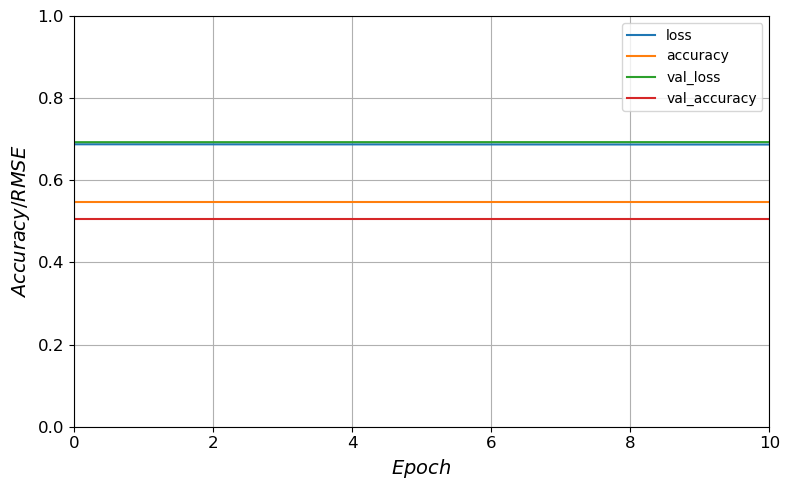

In [66]:
pd.DataFrame(model_history_k_means.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel("$Epoch$", fontsize=14)
plt.ylabel("$Accuracy/RMSE$", fontsize=14)

save_fig("k_means_keras_learning_curves_plot")
plt.show()

231/231 [==============================] - 0s 65us/sample - loss: 0.6916 - accuracy: 0.4978
[0.6916160020993386, 0.4978355]
                      precision    recall  f1-score   support

      No signs of DR       0.00      0.00      0.00       115
Contains signs of DR       0.50      0.99      0.66       116

            accuracy                           0.50       231
           macro avg       0.25      0.50      0.33       231
        weighted avg       0.25      0.50      0.33       231



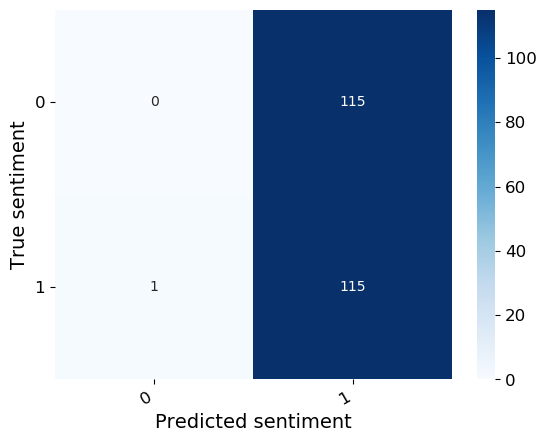

In [38]:
X_test_k_mean_label = kmeans_optimum.predict(messidor_test_prep)
hot_encoder = OneHotEncoder()
X_test_k_mean_label = (hot_encoder.fit_transform(X_test_k_mean_label.reshape(-1, 1))).toarray()
acc = model_NN_k_means.evaluate(X_test_k_mean_label,messidor_test_labels_prep)
print(acc)
y_pred_k_means_label = model_NN_k_means.predict_classes(X_test_k_mean_label)

cm = confusion_matrix(messidor_test_labels_prep, y_pred_k_means_label)
df_cm = pd.DataFrame(cm)#, index=Class_label[:], columns=Class_label[:])
show_confusion_matrix(df_cm)
print(classification_report(messidor_test_labels_prep, y_pred_k_means_label, target_names=Class_label[:]))

## Using euclidian distance to clusters as feature:

In [44]:
# Creating MLP NN
tf.keras.backend.clear_session()

model_NN_k_means_dist = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=X_dist.shape[1]),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")])


In [45]:
model_NN_k_means_dist.compile(loss="binary_crossentropy",
              optimizer =keras.optimizers.SGD(lr=0.001),
              metrics = ["accuracy"])

In [46]:
early_stopping = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
model_history_k_means_dist = model_NN_k_means_dist.fit(X_dist,y,epochs=300,validation_split=0.2,callbacks=[early_stopping])

h 166/300
736/736 [==============================] - 0s 68us/sample - loss: 0.6484 - accuracy: 0.5910 - val_loss: 0.6468 - val_accuracy: 0.5978
Epoch 167/300
736/736 [==============================] - 0s 114us/sample - loss: 0.6484 - accuracy: 0.5910 - val_loss: 0.6467 - val_accuracy: 0.5978
Epoch 168/300
736/736 [==============================] - 0s 95us/sample - loss: 0.6483 - accuracy: 0.5910 - val_loss: 0.6467 - val_accuracy: 0.5924
Epoch 169/300
736/736 [==============================] - 0s 71us/sample - loss: 0.6482 - accuracy: 0.5910 - val_loss: 0.6466 - val_accuracy: 0.5924
Epoch 170/300
736/736 [==============================] - 0s 91us/sample - loss: 0.6481 - accuracy: 0.5897 - val_loss: 0.6465 - val_accuracy: 0.5924
Epoch 171/300
736/736 [==============================] - 0s 79us/sample - loss: 0.6480 - accuracy: 0.5910 - val_loss: 0.6464 - val_accuracy: 0.5924
Epoch 172/300
736/736 [==============================] - 0s 83us/sample - loss: 0.6479 - accuracy: 0.5897 - val_los

In [47]:
model_history_k_means_dist.history['val_accuracy'][-1],model_history_k_means_dist.history['accuracy'][-1]

(0.5869565, 0.5910326)

231/231 [==============================] - 0s 82us/sample - loss: 0.6643 - accuracy: 0.5974
[0.6642722149431963, 0.5974026]
                      precision    recall  f1-score   support

      No signs of DR       0.62      0.49      0.55       115
Contains signs of DR       0.58      0.71      0.64       116

            accuracy                           0.60       231
           macro avg       0.60      0.60      0.59       231
        weighted avg       0.60      0.60      0.59       231



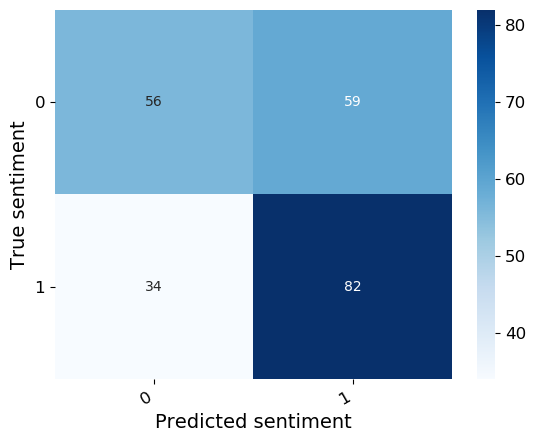

In [67]:
X_test_k_mean_dist = kmeans_optimum.transform(messidor_test_prep)
scaler = StandardScaler()
X_test_k_mean_dist = scaler.fit_transform(X_test_k_mean_dist)
acc = model_NN_k_means_dist.evaluate(X_test_k_mean_dist,messidor_test_labels_prep)
print(acc)
y_pred_k_means_dist = model_NN_k_means_dist.predict_classes(X_test_k_mean_dist)

cm = confusion_matrix(messidor_test_labels_prep, y_pred_k_means_dist)
df_cm = pd.DataFrame(cm)#, index=Class_label[:], columns=Class_label[:])
show_confusion_matrix(df_cm)
print(classification_report(messidor_test_labels_prep, y_pred_k_means_dist, target_names=Class_label[:]))

# Gaussian Mixture (EM)

In [91]:
gm_optimum = GaussianMixture(n_components=9, n_init=10, covariance_type='full',random_state=9).fit(X)
y_pred_gm = gm_optimum.predict(X)

In [92]:
hot_encoder = OneHotEncoder()
x_gm = (hot_encoder.fit_transform(y_pred_gm.reshape(-1, 1))).toarray()

In [61]:
centers_gm=gm_optimum.means_
dist_feature_gm = np.zeros((X.shape[0],3))
for i in range(X.shape[0]):
    dist_feature_gm[i]=np.sqrt(np.sum(((X[i]-centers)**2),axis=1))
scaler = StandardScaler()
X_dist_gm = scaler.fit_transform(dist_feature_gm)

 0.6613 - val_accuracy: 0.5380
Epoch 47/200
736/736 [==============================] - 0s 94us/sample - loss: 0.6638 - accuracy: 0.5870 - val_loss: 0.6608 - val_accuracy: 0.5380
Epoch 48/200
736/736 [==============================] - 0s 84us/sample - loss: 0.6634 - accuracy: 0.5815 - val_loss: 0.6605 - val_accuracy: 0.5380
Epoch 49/200
736/736 [==============================] - 0s 80us/sample - loss: 0.6631 - accuracy: 0.5856 - val_loss: 0.6601 - val_accuracy: 0.5707
Epoch 50/200
736/736 [==============================] - 0s 95us/sample - loss: 0.6628 - accuracy: 0.5829 - val_loss: 0.6596 - val_accuracy: 0.5707
Epoch 51/200
736/736 [==============================] - 0s 99us/sample - loss: 0.6625 - accuracy: 0.6060 - val_loss: 0.6593 - val_accuracy: 0.5707
Epoch 52/200
736/736 [==============================] - 0s 107us/sample - loss: 0.6622 - accuracy: 0.6060 - val_loss: 0.6588 - val_accuracy: 0.5707
Epoch 53/200
736/736 [==============================] - 0s 91us/sample - loss: 0.6620 

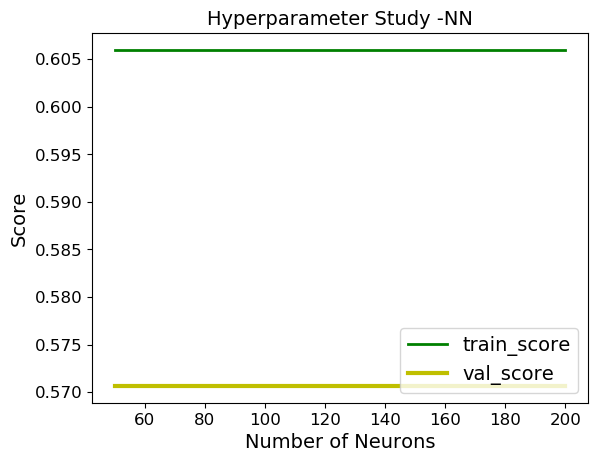

In [172]:
# number of neurons vs score
range_n=[50,100,200]
nn_parameter_study(x_gm,y,n=100,l=2,lr=0.01,epochs=200,range_n=range_n,range_lr=None)

oss: 0.6457 - accuracy: 0.6060 - val_loss: 0.6429 - val_accuracy: 0.5707
Epoch 229/300
736/736 [==============================] - 0s 87us/sample - loss: 0.6456 - accuracy: 0.6060 - val_loss: 0.6432 - val_accuracy: 0.5707
Train on 736 samples, validate on 184 samples
Epoch 1/300
736/736 [==============================] - 0s 605us/sample - loss: 0.6899 - accuracy: 0.5408 - val_loss: 0.6902 - val_accuracy: 0.5054
Epoch 2/300
736/736 [==============================] - 0s 87us/sample - loss: 0.6881 - accuracy: 0.5584 - val_loss: 0.6892 - val_accuracy: 0.5598
Epoch 3/300
736/736 [==============================] - 0s 87us/sample - loss: 0.6867 - accuracy: 0.5788 - val_loss: 0.6884 - val_accuracy: 0.5598
Epoch 4/300
736/736 [==============================] - 0s 90us/sample - loss: 0.6854 - accuracy: 0.5815 - val_loss: 0.6877 - val_accuracy: 0.5707
Epoch 5/300
736/736 [==============================] - 0s 83us/sample - loss: 0.6844 - accuracy: 0.6005 - val_loss: 0.6869 - val_accuracy: 0.5707
Ep

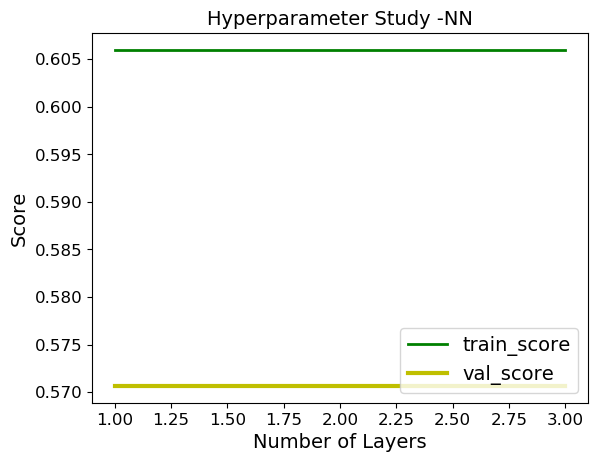

In [176]:
nn_parameter_study(x_gm,y,n=50,lr=0.01,l=2,epochs=300,range_n=None,num_layer=3,range_lr=None)

In [ ]:
range_lr =[0.001,0.005,0.01,]
nn_parameter_study(x_gm,y,n=50,lr=0.01,l=1,epochs=200,range_n=None,range_lr=range_lr)

In [81]:
x_gm.shape[1]

9

In [71]:
# Creating MLP
tf.keras.backend.clear_session()

model_NN_gm = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=x_gm.shape[1]),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")])

In [72]:
model_NN_gm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                500       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 551
Trainable params: 551
Non-trainable params: 0
_________________________________________________________________


In [73]:
model_NN_gm.compile(loss="binary_crossentropy",
              optimizer =keras.optimizers.SGD(lr=0.005),
              metrics = ["accuracy"])

In [75]:
early_stopping = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
model_history_gm = model_NN_gm.fit(x_gm,y,epochs=300,validation_split=0.2,callbacks=[early_stopping])

=========================] - 0s 107us/sample - loss: 0.6618 - accuracy: 0.6060 - val_loss: 0.6590 - val_accuracy: 0.5707
Epoch 167/300
736/736 [==============================] - 0s 88us/sample - loss: 0.6617 - accuracy: 0.6060 - val_loss: 0.6588 - val_accuracy: 0.5707
Epoch 168/300
736/736 [==============================] - 0s 101us/sample - loss: 0.6616 - accuracy: 0.6060 - val_loss: 0.6587 - val_accuracy: 0.5707
Epoch 169/300
736/736 [==============================] - 0s 83us/sample - loss: 0.6615 - accuracy: 0.6060 - val_loss: 0.6586 - val_accuracy: 0.5707
Epoch 170/300
736/736 [==============================] - 0s 120us/sample - loss: 0.6614 - accuracy: 0.6060 - val_loss: 0.6584 - val_accuracy: 0.5707
Epoch 171/300
736/736 [==============================] - 0s 162us/sample - loss: 0.6613 - accuracy: 0.6060 - val_loss: 0.6583 - val_accuracy: 0.5707
Epoch 172/300
736/736 [==============================] - 0s 143us/sample - loss: 0.6612 - accuracy: 0.6060 - val_loss: 0.6581 - val_accu

In [76]:
model_history_gm.history['val_accuracy'][-1],model_history_gm.history['accuracy'][-1]

(0.5706522, 0.60597825)

Saving figure gm_keras_learning_curves_plot


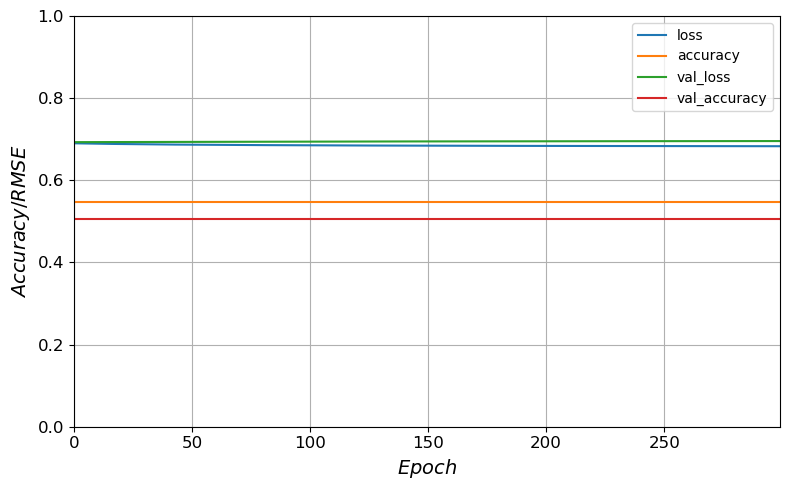

In [182]:
pd.DataFrame(model_history_k_means.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel("$Epoch$", fontsize=14)
plt.ylabel("$Accuracy/RMSE$", fontsize=14)

save_fig("gm_keras_learning_curves_plot")
plt.show()

(231,)
(231, 9)
231/231 [==============================] - 0s 95us/sample - loss: 0.6626 - accuracy: 0.5411
[0.6626130662439189, 0.54112554]
                      precision    recall  f1-score   support

      No signs of DR       0.60      0.24      0.35       115
Contains signs of DR       0.53      0.84      0.65       116

            accuracy                           0.54       231
           macro avg       0.56      0.54      0.50       231
        weighted avg       0.56      0.54      0.50       231



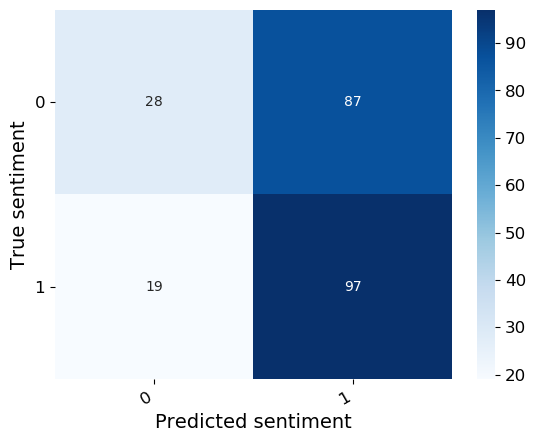

In [94]:
X_test_gm_label = gm_optimum.predict(messidor_test_prep)
X_test_gm_label = (hot_encoder.transform(X_test_gm_label.reshape(-1, 1))).toarray()
acc = model_NN_gm.evaluate(X_test_gm_label,messidor_test_labels_prep)
print(acc)
y_pred_gm_label = model_NN_gm.predict_classes(X_test_gm_label)

cm = confusion_matrix(messidor_test_labels_prep, y_pred_gm_label)
df_cm = pd.DataFrame(cm)#, index=Class_label[:], columns=Class_label[:])
show_confusion_matrix(df_cm)
print(classification_report(messidor_test_labels_prep, y_pred_gm_label, target_names=Class_label[:]))

## Using distance to clusters means as feature:

In [100]:
tf.keras.backend.clear_session()

model_NN_gm_dist = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=X_dist_gm.shape[1]),
    keras.layers.Dense(50, activation="relu"),

    keras.layers.Dense(1, activation="sigmoid")])

In [101]:
model_NN_gm_dist.compile(loss="binary_crossentropy",
              optimizer =keras.optimizers.SGD(lr=0.01),
              metrics = ["accuracy"])

In [102]:
early_stopping = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
model_history_gm_dist = model_NN_gm_dist.fit(X_dist_gm,y,epochs=300,validation_split=0.2,callbacks=[early_stopping])

======================] - 0s 87us/sample - loss: 0.6255 - accuracy: 0.6019 - val_loss: 0.6288 - val_accuracy: 0.6304
Epoch 122/300
736/736 [==============================] - 0s 99us/sample - loss: 0.6254 - accuracy: 0.6033 - val_loss: 0.6287 - val_accuracy: 0.6304
Epoch 123/300
736/736 [==============================] - 0s 123us/sample - loss: 0.6253 - accuracy: 0.6033 - val_loss: 0.6287 - val_accuracy: 0.6304
Epoch 124/300
736/736 [==============================] - 0s 83us/sample - loss: 0.6252 - accuracy: 0.6033 - val_loss: 0.6286 - val_accuracy: 0.6304
Epoch 125/300
736/736 [==============================] - 0s 87us/sample - loss: 0.6252 - accuracy: 0.6019 - val_loss: 0.6286 - val_accuracy: 0.6304
Epoch 126/300
736/736 [==============================] - 0s 107us/sample - loss: 0.6251 - accuracy: 0.6019 - val_loss: 0.6286 - val_accuracy: 0.6304
Epoch 127/300
736/736 [==============================] - 0s 111us/sample - loss: 0.6250 - accuracy: 0.6019 - val_loss: 0.6285 - val_accuracy:

In [103]:
# 1 layer with 50 nodes
model_history_gm_dist.history['val_accuracy'][-1],model_history_gm_dist.history['accuracy'][-1]

(0.6413044, 0.625)

231/231 [==============================] - 0s 81us/sample - loss: 0.6728 - accuracy: 0.5974
[0.6728386989919655, 0.5974026]
                      precision    recall  f1-score   support

      No signs of DR       0.58      0.70      0.64       115
Contains signs of DR       0.63      0.49      0.55       116

            accuracy                           0.60       231
           macro avg       0.60      0.60      0.59       231
        weighted avg       0.60      0.60      0.59       231



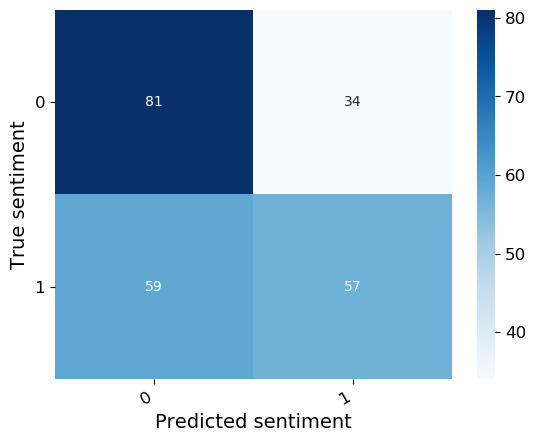

In [106]:
dist_feature_gm_test = np.zeros((messidor_test_prep.shape[0],3))
for i in range(messidor_test_prep.shape[0]):
    dist_feature_gm_test[i]=np.sqrt(np.sum(((messidor_test_prep[i]-centers)**2),axis=1))

X_dist_gm_test = scaler.transform(dist_feature_gm_test)


acc = model_NN_gm_dist.evaluate(X_dist_gm_test,messidor_test_labels_prep)
print(acc)
y_pred_gm_dist = model_NN_gm_dist.predict_classes(X_dist_gm_test)

cm = confusion_matrix(messidor_test_labels_prep, y_pred_gm_dist)
df_cm = pd.DataFrame(cm)#, index=Class_label[:], columns=Class_label[:])
show_confusion_matrix(df_cm)
print(classification_report(messidor_test_labels_prep, y_pred_gm_dist, target_names=Class_label[:]))